In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from sklearn.preprocessing import LabelEncoder

In [2]:
# Check data info
root_dir = "/home/fmg2/v-thanh/Code/datasets/VNDALE"
data_info = pd.read_excel( f"{root_dir}/utils/data_information.xlsx", sheet_name='data_info')

In [3]:
data_info.head()

,index,combination,data1,data2,data3,data4
0,0,[0],20240121_data_Nodevice_1.xlsx,20240121_data_Nodevice_2.xlsx,20240121_data_Nodevice_3.xlsx,20240121_data_Nodevice_4.xlsx
1,1,[1],20240113_data_den_1.xlsx,20240114_data_den_2.xlsx,20240115_data_den_3.xlsx,20240121_data_den_4.xlsx
2,2,[2],20240113_data_quat_1.xlsx,20240114_data_quat_2.xlsx,20240115_data_quat_3.xlsx,20240121_data_quat_4.xlsx
3,3,"[1, 2]",20240114_data_den_quat_1.xlsx,20240114_data_den_quat_2.xlsx,20240115_data_den_quat_3.xlsx,20240121_data_den_quat_4.xlsx
4,4,[3],20240113_data_maysay_1.xlsx,20240114_data_maysay_2.xlsx,20240115_data_maysay_3.xlsx,20240121_data_maysay_4.xlsx


In [7]:
data_info = data_info[data_info["combination"].isin(["[0]", "[1]", "[2]", "[3]", "[4]", "[5]", "[6]", "[7]"])]
data_info.reset_index(drop=True, inplace=True)
data_info

,index,combination,data1,data2,data3,data4
0,0,[0],20240121_data_Nodevice_1.xlsx,20240121_data_Nodevice_2.xlsx,20240121_data_Nodevice_3.xlsx,20240121_data_Nodevice_4.xlsx
1,1,[1],20240113_data_den_1.xlsx,20240114_data_den_2.xlsx,20240115_data_den_3.xlsx,20240121_data_den_4.xlsx
2,2,[2],20240113_data_quat_1.xlsx,20240114_data_quat_2.xlsx,20240115_data_quat_3.xlsx,20240121_data_quat_4.xlsx
3,4,[3],20240113_data_maysay_1.xlsx,20240114_data_maysay_2.xlsx,20240115_data_maysay_3.xlsx,20240121_data_maysay_4.xlsx
4,8,[4],20240113_data_maylockk_1.xlsx,20240114_data_maylockk_2.xlsx,20240115_data_maylockk_3.xlsx,20240121_data_maylockk_4.xlsx
5,16,[5],20240115_data_mayep_1.xlsx,20240115_data_mayep_2.xlsx,20240115_data_mayep_3.xlsx,20240121_data_mayep_4.xlsx
6,32,[6],20240116_data_amnuoc_1.xlsx,20240118_data_amnuoc_2.xlsx,20240120_data_amnuoc_3.xlsx,20240121_data_amnuoc_4.xlsx
7,64,[7],20240116_data_sacmt_1.xlsx,20240118_data_sacmt_2.xlsx,20240120_data_sacmt_3.xlsx,20240122_data_sacmt_4.xlsx


In [5]:
all_labels = data_info["combination"].unique().tolist()
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
label_encoder.classes_

array(['[0]', '[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]'],
      dtype='<U3')

In [ ]:
utils_path = os.path.join(root_dir, "utils")
original_data_path = os.path.join(root_dir, "original_data")

In [7]:
np.save(os.path.join(utils_path, "label_encoder.npy"), label_encoder.classes_)

In [24]:
def cal_rms(inputs):
    return np.sqrt(np.mean(np.power(inputs, 2)))

def cal_all_rms(instant_current, instant_voltage, pfs):
    Irms = cal_rms(instant_current)
    Urms = cal_rms(instant_voltage)
    avg_pf = np.mean(pfs) / 100
    P = Urms * Irms * avg_pf
    S = Urms * Irms
    Q = Urms * Irms * (1 - avg_pf ** 2)
    return Irms, Urms, avg_pf, P, Q, S

def get_features(df):
    instant_current = df["currentWaveform"].values
    instant_voltage = df["voltageWaveform"].values
    pfs = df["powerFactor"].values
    return cal_all_rms(instant_current, instant_voltage, pfs)

def cal_RMS_features(window_df, window_size, label):
    process_datas = []
    for i in range(window_size, len(window_df)):
        window = window_df.iloc[i - window_size:i]
        time = window["Time"].values[0]
        In = window["currentWaveform"].values[0]
        Un = window["voltageWaveform"].values[0]
        pfN = window["powerFactor"].values[0]/100
        Irms, Urms, avg_pf, P, Q, S = get_features(window)
        process_datas.append([time, In, Un, pfN, Irms, Urms, avg_pf, P, Q, S, label])
    return pd.DataFrame(process_datas, columns=["Time", "In", "Un", "PF_n", "Irms", "Urms", "MeanPF", "P", "Q", "S", "Label"])

def get_data(base_path, data_info_df, select_row, data_index, window_size):
    # Get data
    combination = data_info_df.iloc[select_row]["combination"]
    data_path = data_info_df.iloc[select_row][f"data{data_index}"].replace(".xlsx", ".csv")
    file_path = f"{base_path}/{data_path}"
    
    # Check if file exist
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        if df.shape[0] == 0:
            return None, None
        # Split data into windows of size 2 * window_size
        all_windows = []
        for start in range(0, len(df) - 2 * window_size + 1, window_size):
            window = df.iloc[start:start + 2 * window_size]
            all_windows.append(window)
        return all_windows, combination
    # Return None if file not found
    return None, None

def split_window_data(dataframe, window_size=120, step_size=120):
    """
    Split the dataframe into overlapping windows.
    
    Parameters:
    dataframe: pandas DataFrame with sensor data
    window_size: size of each window
    step_size: step size for sliding window
    
    Returns:
    list of DataFrames, each representing a window
    """
    windows = []
    for start in range(0, len(dataframe) - window_size + 1, step_size):
        end = start + window_size
        df = dataframe.iloc[start:end]
        data = df.values
        windows.append(data)
    return np.array(windows)

In [25]:
window_size = 1800
base_path = os.path.join(root_dir, "original_data")

In [26]:
windows, combination = get_data(base_path, data_info, 1, 1, 1800)

In [27]:
all_data = []
labels = []

for select_row in tqdm(range(len(data_info)), desc="Processing data"):    
    for data_index in range(1, 5):
        all_windows, combination = get_data(base_path, data_info, select_row, data_index, window_size)
        if all_windows is None:
            print(f"[-] Combination {combination} - file {data_index}: {combination} - Not found")
            continue
        # Transform data
        label = label_encoder.transform([combination])[0]
        print(f"[+] Combination {combination} - {label} - file {data_index} - windows: {len(all_windows)}")
        for window in all_windows:
            transform_data = cal_RMS_features(window, window_size, label)
            transform_data = transform_data[["Irms", "MeanPF", "P", "Q", "S"]]
            mini_windows = split_window_data(transform_data, window_size=120, step_size=60)
            if mini_windows is not None:
                all_data.extend(mini_windows)
                labels.extend([label] * len(mini_windows))

all_data = np.array(all_data)
labels = np.array(labels)
print(f"All data shape: {all_data.shape}, Labels shape: {labels.shape}")

Processing data:   0%|          | 0/8 [00:00<?, ?it/s]

[+] Combination [0] - 0 - file 1 - windows: 99
[+] Combination [0] - 0 - file 2 - windows: 99
[+] Combination [0] - 0 - file 3 - windows: 99
[+] Combination [0] - 0 - file 4 - windows: 99
[-] Combination None - file 1: None - Not found
[+] Combination [1] - 1 - file 2 - windows: 199
[+] Combination [1] - 1 - file 3 - windows: 43
[+] Combination [1] - 1 - file 4 - windows: 99
[+] Combination [2] - 2 - file 1 - windows: 99
[+] Combination [2] - 2 - file 2 - windows: 99
[+] Combination [2] - 2 - file 3 - windows: 99
[+] Combination [2] - 2 - file 4 - windows: 99
[+] Combination [3] - 3 - file 1 - windows: 99
[+] Combination [3] - 3 - file 2 - windows: 99
[+] Combination [3] - 3 - file 3 - windows: 99
[+] Combination [3] - 3 - file 4 - windows: 99
[+] Combination [4] - 4 - file 1 - windows: 99
[-] Combination None - file 2: None - Not found
[-] Combination None - file 3: None - Not found
[+] Combination [4] - 4 - file 4 - windows: 97
[+] Combination [5] - 5 - file 1 - windows: 99
[+] Combi

In [28]:
len(all_data), len(labels)

(81258, 81258)

In [29]:
all_data[0]

array([[0.00213814, 0.91571167, 0.3245362 , 0.05722714, 0.35440872],
       [0.00213775, 0.91574652, 0.32445978, 0.05718886, 0.35431177],
       [0.00213763, 0.91575657, 0.32445251, 0.05718043, 0.35429996],
       [0.00213704, 0.915777  , 0.32441198, 0.05715876, 0.35424779],
       [0.00213664, 0.91579916, 0.32438824, 0.05713882, 0.3542133 ],
       [0.00213619, 0.91566319, 0.32427078, 0.0572148 , 0.35413762],
       [0.00213733, 0.91567756, 0.32443403, 0.05723338, 0.35431034],
       [0.00213736, 0.91564874, 0.32440148, 0.05724814, 0.35428594],
       [0.00213678, 0.91568225, 0.32431859, 0.05720968, 0.35418246],
       [0.00213668, 0.91567822, 0.32431976, 0.05721275, 0.35418529],
       [0.00213714, 0.915672  , 0.32442563, 0.05723586, 0.35430332],
       [0.00213727, 0.9156306 , 0.32443762, 0.05726742, 0.35433244],
       [0.00213714, 0.9155892 , 0.3244003 , 0.05729028, 0.3543077 ],
       [0.00213706, 0.91558689, 0.32435893, 0.05728462, 0.3542634 ],
       [0.0021378 , 0.91558458, 0.

In [30]:
labels.shape

(81258,)

In [31]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([11484,  9889, 11484, 11484,  5684, 11484,  8265, 11484]))

In [32]:
X_total = all_data
y_total = labels

In [33]:
from sklearn.model_selection import train_test_split
X_sp, X_atk, y_sp, y_atk = train_test_split(
    X_total, y_total, test_size=0.1, random_state=42, stratify=y_total
)
X_sp_train, X_sp_test, y_sp_train, y_sp_test = train_test_split(
    X_sp, y_sp, test_size=0.2, random_state=42, stratify=y_sp
)
X_atk_train, X_atk_test, y_atk_train, y_atk_test = train_test_split(
    X_atk, y_atk, test_size=0.2, random_state=42, stratify=y_atk
)

In [34]:
print(f"X_atk_train shape: {X_atk_train.shape}, y_atk_train shape: {y_atk_train.shape}, {np.unique(y_atk_train, return_counts=True)}")
print(f"X_atk_test shape: {X_atk_test.shape}, y_atk_test shape: {y_atk_test.shape}, {np.unique(y_atk_test, return_counts=True)}")
print(f"X_sp_train shape: {X_sp_train.shape}, y_sp_train shape: {y_sp_train.shape}, {np.unique(y_sp_train, return_counts=True)}")
print(f"X_sp_test shape: {X_sp_test.shape}, y_sp_test shape: {y_sp_test.shape}, {np.unique(y_sp_test, return_counts=True)}")

X_atk_train shape: (6500, 120, 5), y_atk_train shape: (6500,), (array([0, 1, 2, 3, 4, 5, 6, 7]), array([919, 791, 918, 918, 455, 919, 662, 918]))
X_atk_test shape: (1626, 120, 5), y_atk_test shape: (1626,), (array([0, 1, 2, 3, 4, 5, 6, 7]), array([230, 198, 230, 230, 113, 230, 165, 230]))
X_sp_train shape: (58505, 120, 5), y_sp_train shape: (58505,), (array([0, 1, 2, 3, 4, 5, 6, 7]), array([8268, 7120, 8268, 8269, 4093, 8268, 5950, 8269]))
X_sp_test shape: (14627, 120, 5), y_sp_test shape: (14627,), (array([0, 1, 2, 3, 4, 5, 6, 7]), array([2067, 1780, 2068, 2067, 1023, 2067, 1488, 2067]))


In [35]:
data_path = os.path.join(root_dir, "train_test_np")
print(f"Saving data to {data_path}")

Saving data to /home/fmg2/v-thanh/Code/datasets/VNDALE/train_test_np


In [36]:
np.save(os.path.join(data_path, "X_train_atk.npy"), X_atk_train)
np.save(os.path.join(data_path, "y_train_atk.npy"), y_atk_train)
np.save(os.path.join(data_path, "X_test_atk.npy"), X_atk_test)
np.save(os.path.join(data_path, "y_test_atk.npy"), y_atk_test)

np.save(os.path.join(data_path, "X_train_sp.npy"), X_sp_train)
np.save(os.path.join(data_path, "y_train_sp.npy"), y_sp_train)
np.save(os.path.join(data_path, "X_test_sp.npy"), X_sp_test)
np.save(os.path.join(data_path, "y_test_sp.npy"), y_sp_test)

np.save(os.path.join(original_data_path, "X_total.npy"), X_total)
np.save(os.path.join(original_data_path, "y_total.npy"), y_total)

Data shape: (6500, 120, 5)
Labels shape: (6500,)
Unique labels: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([919, 791, 918, 918, 455, 919, 662, 918]))


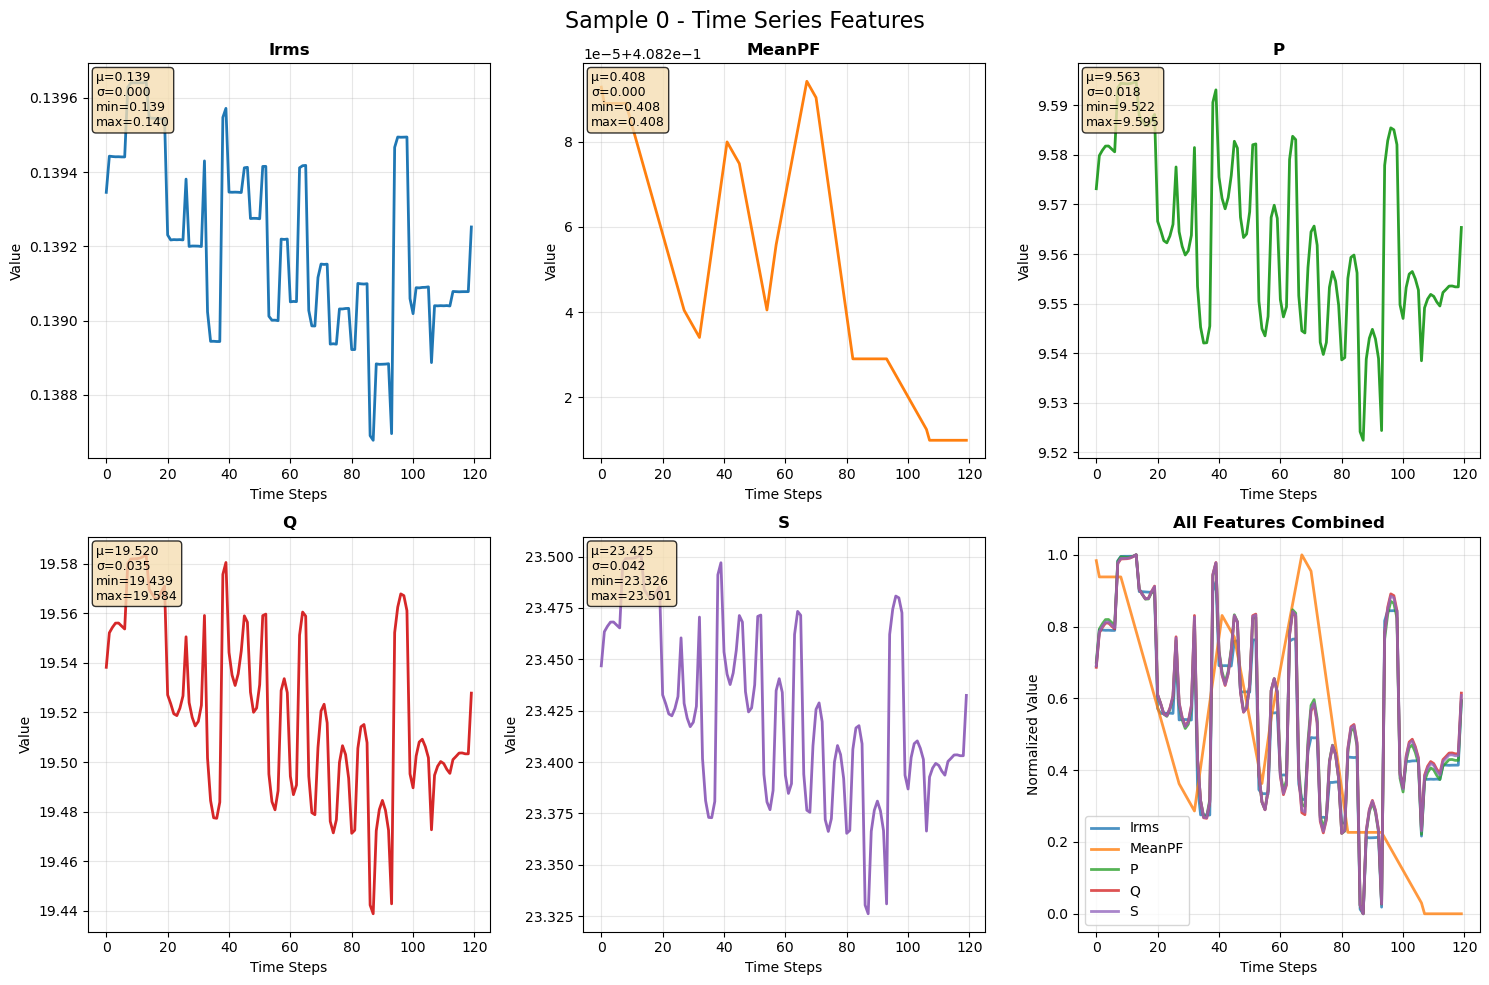

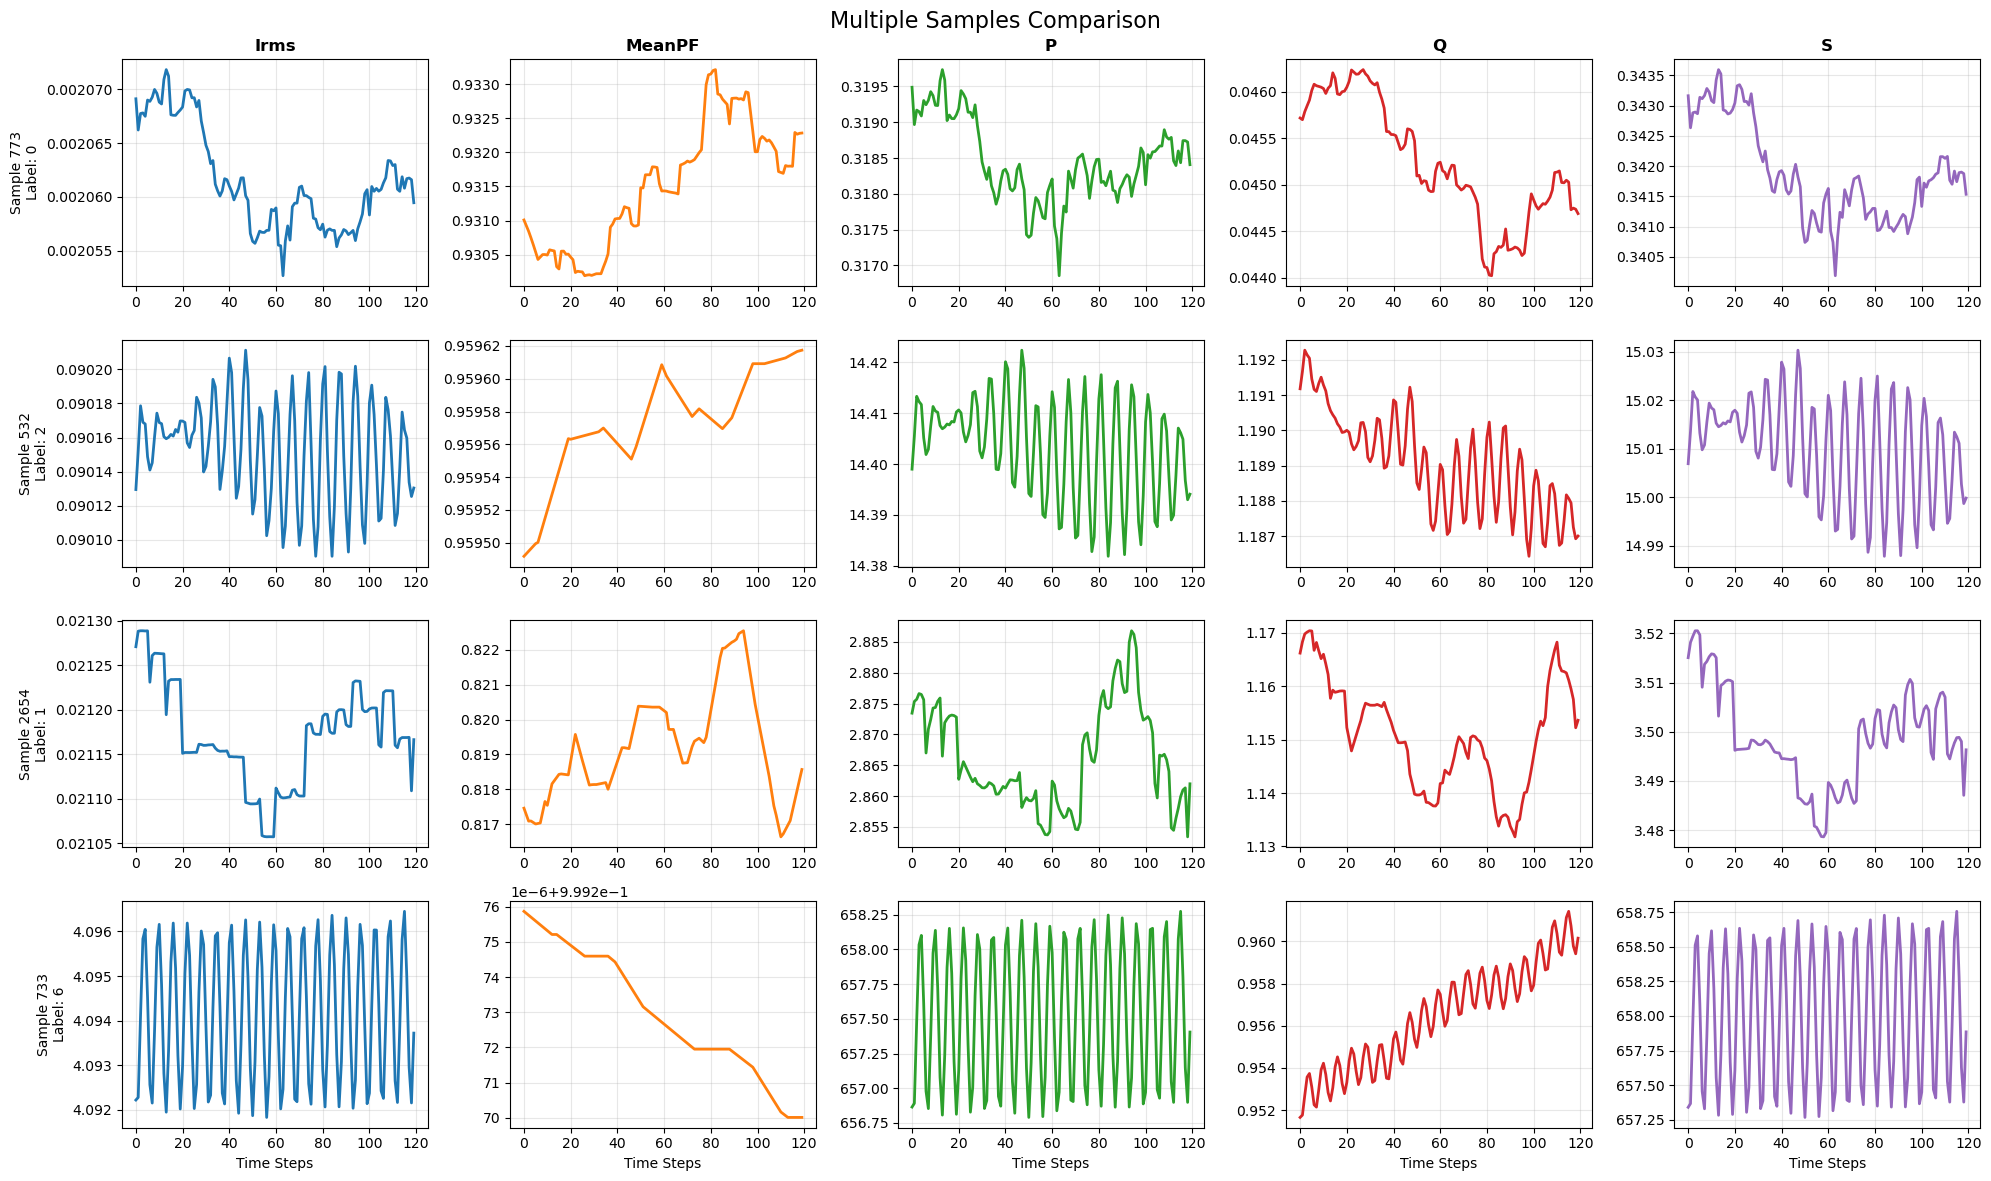

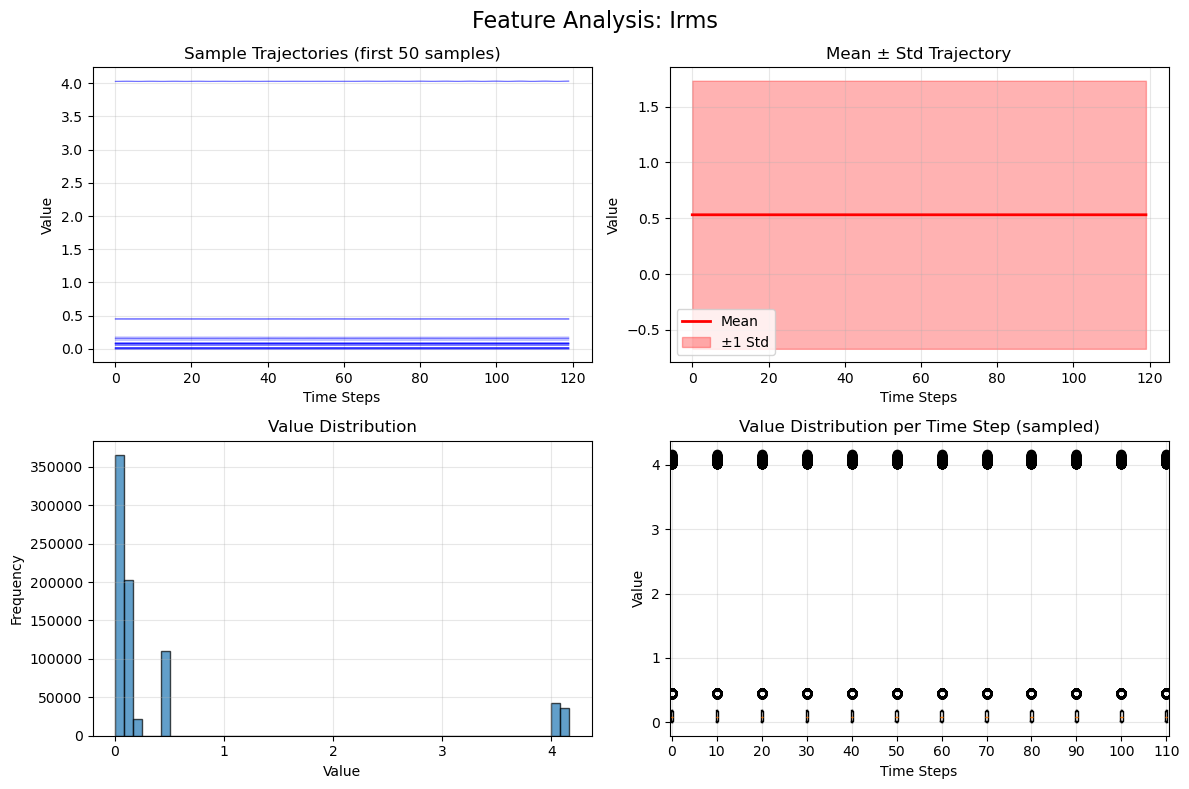

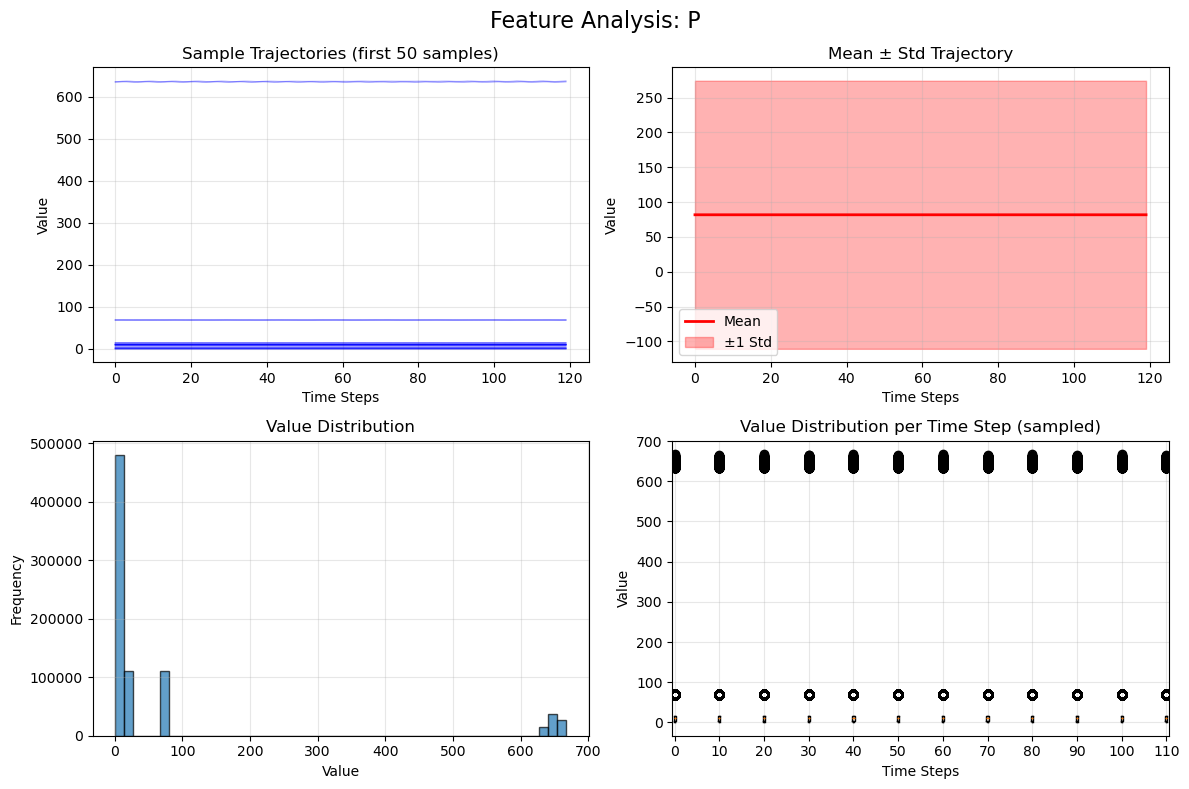

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(X_data, sample_idx=0, figsize=(15, 10)):
    """
    Plot one sample from the dataset showing all features over time
    
    Args:
        X_data: 3D numpy array with shape (n_samples, time_steps, n_features)
        sample_idx: Index of the sample to plot
        figsize: Figure size (width, height)
    """
    # Feature names based on your data processing
    feature_names = ["Irms", "MeanPF", "P", "Q", "S"]
    
    # Get the sample
    sample = X_data[sample_idx]  # Shape: (120, 5)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'Sample {sample_idx} - Time Series Features', fontsize=16)
    
    # Flatten axes for easier indexing
    axes = axes.flatten()
    
    # Plot each feature
    for i, feature_name in enumerate(feature_names):
        axes[i].plot(sample[:, i], linewidth=2, color=f'C{i}')
        axes[i].set_title(f'{feature_name}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)
        
        # Add statistics
        mean_val = np.mean(sample[:, i])
        std_val = np.std(sample[:, i])
        min_val = np.min(sample[:, i])
        max_val = np.max(sample[:, i])
        
        axes[i].text(0.02, 0.98, f'μ={mean_val:.3f}\nσ={std_val:.3f}\nmin={min_val:.3f}\nmax={max_val:.3f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    fontsize=9)
    
    # Plot all features together in the last subplot
    axes[5].set_title('All Features Combined', fontsize=12, fontweight='bold')
    for i, feature_name in enumerate(feature_names):
        # Normalize each feature to [0, 1] for better visualization
        normalized_feature = (sample[:, i] - sample[:, i].min()) / (sample[:, i].max() - sample[:, i].min() + 1e-8)
        axes[5].plot(normalized_feature, label=feature_name, linewidth=2, alpha=0.8)
    
    axes[5].set_xlabel('Time Steps')
    axes[5].set_ylabel('Normalized Value')
    axes[5].legend()
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_multiple_samples(X_data, y_data=None, n_samples=4, figsize=(20, 12)):
    """
    Plot multiple samples to compare patterns
    
    Args:
        X_data: 3D numpy array with shape (n_samples, time_steps, n_features)
        y_data: Labels (optional)
        n_samples: Number of samples to plot
        figsize: Figure size (width, height)
    """
    feature_names = ["Irms", "MeanPF", "P", "Q", "S"]
    
    # Select random samples
    sample_indices = np.random.choice(len(X_data), n_samples, replace=False)
    
    fig, axes = plt.subplots(n_samples, len(feature_names), figsize=figsize)
    fig.suptitle('Multiple Samples Comparison', fontsize=16)
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for row, sample_idx in enumerate(sample_indices):
        sample = X_data[sample_idx]
        label = y_data[sample_idx] if y_data is not None else "Unknown"
        
        for col, feature_name in enumerate(feature_names):
            axes[row, col].plot(sample[:, col], linewidth=2, color=f'C{col}')
            
            if row == 0:
                axes[row, col].set_title(f'{feature_name}', fontsize=12, fontweight='bold')
            
            if col == 0:
                axes[row, col].set_ylabel(f'Sample {sample_idx}\nLabel: {label}', fontsize=10)
            
            if row == n_samples - 1:
                axes[row, col].set_xlabel('Time Steps')
            
            axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_feature_distribution(X_data, feature_idx=0, figsize=(12, 8)):
    """
    Plot distribution of a specific feature across all samples
    
    Args:
        X_data: 3D numpy array with shape (n_samples, time_steps, n_features)
        feature_idx: Index of feature to analyze (0-4)
        figsize: Figure size (width, height)
    """
    feature_names = ["Irms", "MeanPF", "P", "Q", "S"]
    feature_name = feature_names[feature_idx]
    
    # Extract all values for the specific feature
    feature_data = X_data[:, :, feature_idx]  # Shape: (n_samples, time_steps)
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'Feature Analysis: {feature_name}', fontsize=16)
    
    # Plot 1: Multiple sample trajectories
    axes[0, 0].set_title('Sample Trajectories (first 50 samples)')
    for i in range(min(50, len(feature_data))):
        axes[0, 0].plot(feature_data[i], alpha=0.3, color='blue', linewidth=0.5)
    axes[0, 0].set_xlabel('Time Steps')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Mean trajectory with confidence intervals
    axes[0, 1].set_title('Mean ± Std Trajectory')
    mean_trajectory = np.mean(feature_data, axis=0)
    std_trajectory = np.std(feature_data, axis=0)
    time_steps = range(len(mean_trajectory))
    
    axes[0, 1].plot(time_steps, mean_trajectory, 'r-', linewidth=2, label='Mean')
    axes[0, 1].fill_between(time_steps, 
                           mean_trajectory - std_trajectory,
                           mean_trajectory + std_trajectory,
                           alpha=0.3, color='red', label='±1 Std')
    axes[0, 1].set_xlabel('Time Steps')
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Distribution of all values
    axes[1, 0].set_title('Value Distribution')
    axes[1, 0].hist(feature_data.flatten(), bins=50, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Box plot of values per time step (sample every 10 time steps)
    axes[1, 1].set_title('Value Distribution per Time Step (sampled)')
    sample_time_steps = range(0, feature_data.shape[1], 10)
    box_data = [feature_data[:, t] for t in sample_time_steps]
    axes[1, 1].boxplot(box_data, positions=sample_time_steps)
    axes[1, 1].set_xlabel('Time Steps')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Usage examples:
if __name__ == "__main__":
    # Load your data (assuming it's already loaded)
    # X_atk_train = np.load("path/to/X_train_atk.npy")
    # y_atk_train = np.load("path/to/y_train_atk.npy")
    
    print("Data shape:", X_atk_train.shape)
    print("Labels shape:", y_atk_train.shape)
    print("Unique labels:", np.unique(y_atk_train, return_counts=True))
    
    # Plot a single sample
    plot_sample(X_atk_train, sample_idx=0)
    
    # Plot multiple samples for comparison
    plot_multiple_samples(X_atk_train, y_atk_train, n_samples=4)
    
    # Analyze a specific feature
    plot_feature_distribution(X_atk_train, feature_idx=0)  # Irms
    plot_feature_distribution(X_atk_train, feature_idx=2)  # P (Power)